somesh code :

[SCRAPE] Fetching: https://www.iisermohali.ac.in

Top 10 frequency words for https://www.iisermohali.ac.in:
               of : 38
              the : 31
            iiser : 26
           mohali : 25
                a : 18
         sciences : 18
              and : 12
               at : 12
               dr : 11
              for : 11

Top 10 YAKE keywords for https://www.iisermohali.ac.in:
         iiser mohali event : 0.000012
      sciences iiser mohali : 0.000016
       mohali event gallery : 0.000020
    chemical sciences iiser : 0.000024
               iiser mohali : 0.000040
       iiser mohali science : 0.000047
       gallery iiser mohali : 0.000050
      research iiser mohali : 0.000058
     iiser mohali institute : 0.000058
     international yoga day : 0.000059
[SCRAPE] Fetching: https://www.iiserpune.ac.in

Top 10 frequency words for https://www.iiserpune.ac.in:
              and : 27
             pune : 16
               in : 15
            iiser : 14
              the :

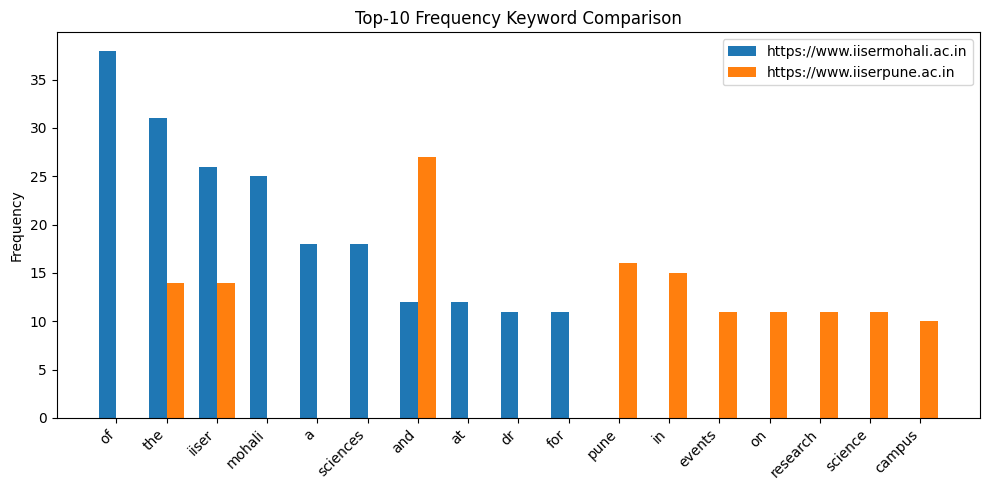

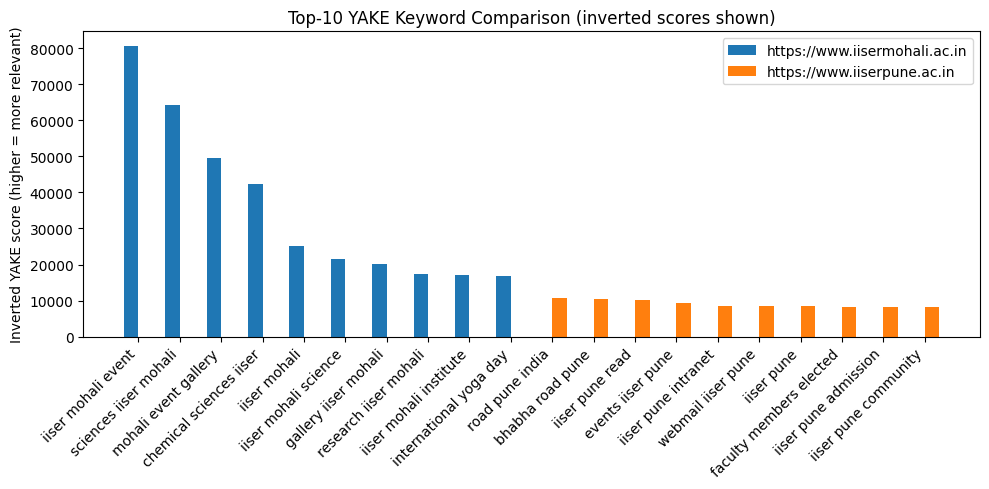


[Visual] Generating word clouds (frequency & YAKE) for both URLs...


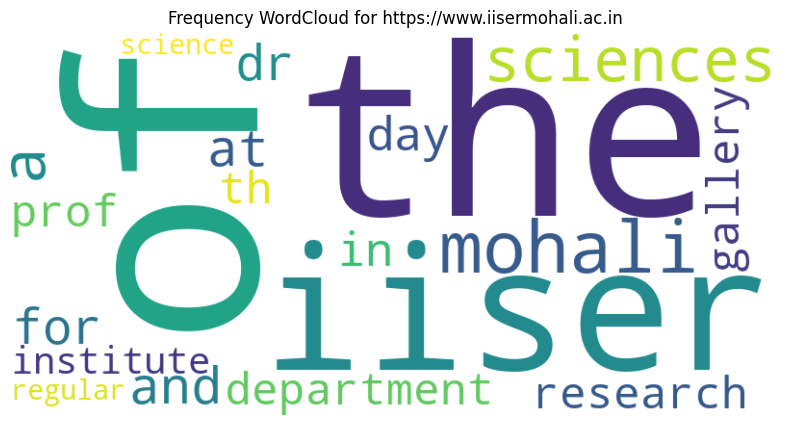

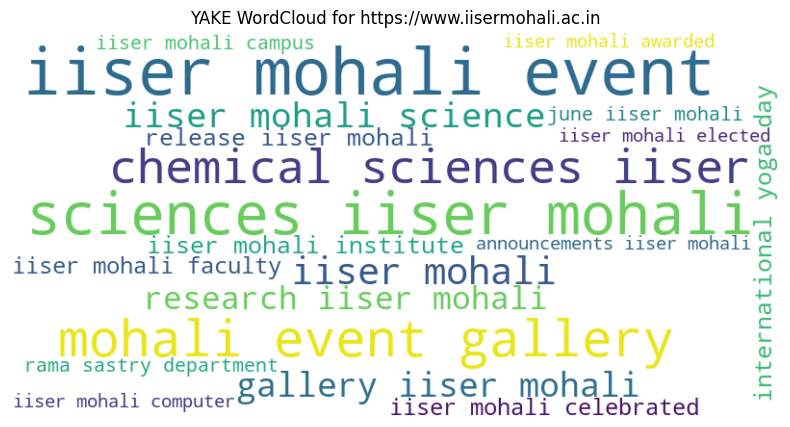

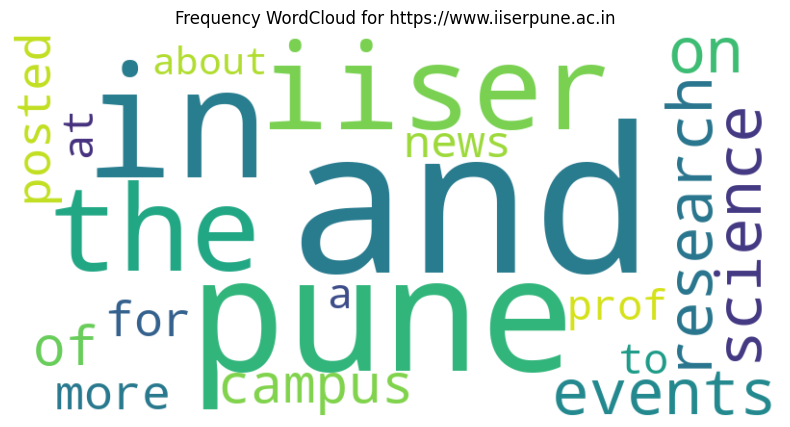

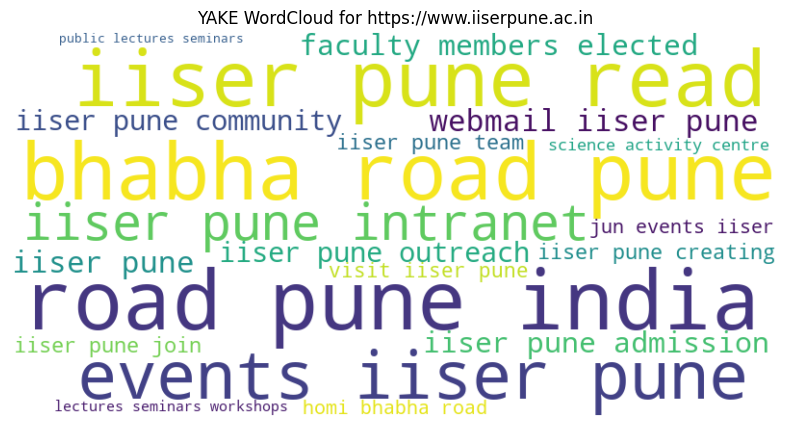

In [1]:
"""
Integrated keyword identification + YAKE + SQLite + visual comparison script.

Features:
- Scrape and clean text from URLs
- Count word frequencies (single words)
- Extract keywords/phrases using YAKE (multi-word allowed)
- Store results in SQLite database (persistent)
- Visualize using bar charts + word clouds
- Compare top-N keywords between two URLs (Option 1 style comparison)
"""

# -----------------------------------------
# IMPORTS
# -----------------------------------------
import requests
from bs4 import BeautifulSoup
import re
from collections import Counter
import sqlite3
import yake
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

# -----------------------------------------
# SCRAPING + CLEANING
# -----------------------------------------
def scrape_and_clean(url: str, timeout: int = 10) -> str:
    """
    Fetch the web page and return cleaned text (letters only, lowercase).
    - Uses requests to GET the page
    - Uses BeautifulSoup to extract visible text
    - Cleans with regex: keep letters and spaces, lowercases
    Returns empty string on failure.
    """
    print(f"[SCRAPE] Fetching: {url}")
    try:
        response = requests.get(url, timeout=timeout)
        response.raise_for_status()
    except Exception as e:
        print(f"[ERROR] Failed to fetch {url}: {e}")
        return ""

    # Get textual content (a simple method: the page's text)
    soup = BeautifulSoup(response.text, "html.parser")
    # get_text(separator=" ") helps keep words separated when tags are removed
    raw_text = soup.get_text(separator=" ", strip=True)

    # Clean: remove non-letter characters, collapse multiple spaces, lowercase
    cleaned = re.sub(r"[^A-Za-z\s]", " ", raw_text)
    cleaned = re.sub(r"\s+", " ", cleaned).strip().lower()
    return cleaned

# -----------------------------------------
# WORD FREQUENCY (SINGLE WORDS)
# -----------------------------------------
def count_word_frequencies(clean_text: str) -> Counter:
    """
    Count single-word frequencies from cleaned text.
    Returns a collections.Counter mapping word -> frequency.
    """
    if not clean_text:
        return Counter()
    words = clean_text.split()
    # Optionally remove short words (single-letter except 'a' and 'i') if needed:
    words = [w for w in words if not (len(w) == 1 and w not in {'a', 'i'})]
    return Counter(words)

# -----------------------------------------
# YAKE EXTRACTION (multi-word allowed)
# -----------------------------------------
def extract_keywords_yake(clean_text: str, top_n: int = 20, max_ngram_size: int = 3) -> List[Tuple[str, float]]:
    """
    Use YAKE to extract keywords/phrases.
    - clean_text: the cleaned page text
    - top_n: how many keywords to return
    - max_ngram_size: 1 for single words, 2-3 to allow phrases
    Returns a list of (keyword, score) where lower score => more relevant.
    """
    if not clean_text:
        return []

    # Initialize YAKE extractor with English defaults and chosen n-gram size
    kw_extractor = yake.KeywordExtractor(
        lan="en",
        n=max_ngram_size,
        dedupLim=0.9,   # deduplication threshold (0..1)
        top=top_n,
        features=None
    )
    keywords = kw_extractor.extract_keywords(clean_text)
    # YAKE returns (keyword, score) tuples
    return keywords

# -----------------------------------------
# DATABASE (SQLite) - CREATE / SAVE / READ
# -----------------------------------------
def init_db(db_path: str = "keywords_compare.db") -> sqlite3.Connection:
    """
    Create/connect the SQLite DB and ensure required tables exist.
    Tables:
      - word_counts(url, word, frequency)         : single-word frequencies
      - yake_keywords(url, keyword, score)        : YAKE keywords & scores
    """
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    # Create tables; simple schema (no ID column required for this app)
    cur.execute("""
    CREATE TABLE IF NOT EXISTS word_counts (
        url TEXT NOT NULL,
        word TEXT NOT NULL,
        frequency INTEGER NOT NULL,
        UNIQUE(url, word)
    )
    """)

    cur.execute("""
    CREATE TABLE IF NOT EXISTS yake_keywords (
        url TEXT NOT NULL,
        keyword TEXT NOT NULL,
        score REAL NOT NULL,
        UNIQUE(url, keyword)
    )
    """)

    # Commit and return connection
    conn.commit()
    return conn

def save_word_counts(conn: sqlite3.Connection, url: str, counter: Counter):
    """
    Save (url, word, frequency) into word_counts table.
    We replace existing rows for the url (simple approach: delete then insert).
    """
    cur = conn.cursor()
    cur.execute("DELETE FROM word_counts WHERE url = ?", (url,))
    data = [(url, w, int(freq)) for w, freq in counter.items()]
    # Use executemany for efficiency
    cur.executemany("INSERT OR REPLACE INTO word_counts (url, word, frequency) VALUES (?, ?, ?)", data)
    conn.commit()

def save_yake_keywords(conn: sqlite3.Connection, url: str, keywords: List[Tuple[str, float]]):
    """
    Save YAKE keywords into yake_keywords table.
    We delete existing rows for url and insert the new list.
    """
    cur = conn.cursor()
    cur.execute("DELETE FROM yake_keywords WHERE url = ?", (url,))
    data = [(url, kw, float(score)) for kw, score in keywords]
    cur.executemany("INSERT OR REPLACE INTO yake_keywords (url, keyword, score) VALUES (?, ?, ?)", data)
    conn.commit()

def get_top_n_words(conn: sqlite3.Connection, url: str, n: int = 10) -> List[Tuple[str, int]]:
    """
    Return top-n words (word, frequency) ordered by frequency desc for a url.
    """
    cur = conn.cursor()
    cur.execute("""
        SELECT word, frequency FROM word_counts
        WHERE url = ?
        ORDER BY frequency DESC
        LIMIT ?
    """, (url, n))
    return cur.fetchall()

def get_top_n_yake(conn: sqlite3.Connection, url: str, n: int = 10) -> List[Tuple[str, float]]:
    """
    Return top-n YAKE keywords (keyword, score) ordered by ascending score (lower = better).
    """
    cur = conn.cursor()
    cur.execute("""
        SELECT keyword, score FROM yake_keywords
        WHERE url = ?
        ORDER BY score ASC
        LIMIT ?
    """, (url, n))
    return cur.fetchall()

# -----------------------------------------
# VISUALIZATION HELPERS: BAR CHARTS + WORDCLOUDS
# -----------------------------------------
def plot_bar_grouped_freqs(conn: sqlite3.Connection, url1: str, url2: str, top_n: int = 10, figsize=(10,5)):
    """
    Compare the top-N frequency words from url1 and url2 using a grouped bar chart.
    We use the union of the two top-list words to show side-by-side counts (0 if absent).
    """
    top1 = get_top_n_words(conn, url1, top_n)
    top2 = get_top_n_words(conn, url2, top_n)

    # Words sets & union
    words1 = [w for w, f in top1]
    words2 = [w for w, f in top2]
    union_words = list(dict.fromkeys(words1 + words2))  # maintain order: url1 then url2 extras

    # Build arrays of frequencies aligned to union_words
    freqs1 = []
    freqs2 = []
    freq_map1 = {w: f for w, f in top1}
    freq_map2 = {w: f for w, f in top2}
    for w in union_words:
        freqs1.append(freq_map1.get(w, 0))
        freqs2.append(freq_map2.get(w, 0))

    x = np.arange(len(union_words))
    width = 0.35

    plt.figure(figsize=figsize)
    plt.bar(x - width/2, freqs1, width, label=url1)
    plt.bar(x + width/2, freqs2, width, label=url2)
    plt.xticks(x, union_words, rotation=45, ha='right')
    plt.ylabel("Frequency")
    plt.title(f"Top-{top_n} Frequency Keyword Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_bar_grouped_yake(conn: sqlite3.Connection, url1: str, url2: str, top_n: int = 10, figsize=(10,5)):
    """
    Compare top-N YAKE keywords for both URLs.
    YAKE scores: lower = better; we invert scores to show 'importance' (higher = more important)
    """
    y1 = get_top_n_yake(conn, url1, top_n)
    y2 = get_top_n_yake(conn, url2, top_n)

    kws1 = [kw for kw, s in y1]
    kws2 = [kw for kw, s in y2]
    union_kws = list(dict.fromkeys(kws1 + kws2))

    imp1 = []
    imp2 = []
    map1 = {kw: (1.0/score if score>0 else 0.0) for kw, score in y1}
    map2 = {kw: (1.0/score if score>0 else 0.0) for kw, score in y2}

    for kw in union_kws:
        imp1.append(map1.get(kw, 0.0))
        imp2.append(map2.get(kw, 0.0))

    x = np.arange(len(union_kws))
    width = 0.35

    plt.figure(figsize=figsize)
    plt.bar(x - width/2, imp1, width, label=url1)
    plt.bar(x + width/2, imp2, width, label=url2)
    plt.xticks(x, union_kws, rotation=45, ha='right')
    plt.ylabel("Inverted YAKE score (higher = more relevant)")
    plt.title(f"Top-{top_n} YAKE Keyword Comparison (inverted scores shown)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_wordcloud_from_freqs(freq_map: dict, title: str = "WordCloud", figsize=(10,5)):
    """
    Generic wordcloud generator from a {word:weight} mapping.
    """
    if not freq_map:
        print("[WORDCLOUD] No data to plot.")
        return
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq_map)
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

def plot_wordcloud_frequencies(conn: sqlite3.Connection, url: str, top_n: int = 50):
    """
    Create wordcloud from top-N frequency words (weights = frequency).
    """
    top = get_top_n_words(conn, url, top_n)
    freq_map = {w: f for w, f in top}
    plot_wordcloud_from_freqs(freq_map, title=f"Frequency WordCloud for {url}")

def plot_wordcloud_yake(conn: sqlite3.Connection, url: str, top_n: int = 50):
    """
    Create wordcloud from top-N YAKE keywords.
    Convert YAKE score -> importance by inversion (1/score).
    """
    top = get_top_n_yake(conn, url, top_n)
    # Avoid division by zero
    wmap = {}
    for kw, score in top:
        try:
            wmap[kw] = 1.0 / float(score) if float(score) > 0 else 0.0
        except Exception:
            wmap[kw] = 0.0
    plot_wordcloud_from_freqs(wmap, title=f"YAKE WordCloud for {url}")

# -----------------------------------------
# COMPARISON — Option 1: Top-N lists comparison
# -----------------------------------------
def compare_top_n_between_urls(conn: sqlite3.Connection, url1: str, url2: str, top_n: int = 10):
    """
    Compare top-N words and YAKE keywords between url1 and url2.
    Steps:
      - Fetch top-N by frequency and by YAKE for each URL
      - Compute common and unique keywords (for each method)
      - Print summary (counts and lists)
      - Plot grouped bar charts for frequency & YAKE (inverted scores)
      - Show wordclouds side by side (caller can call individually)
    """
    print("\n=== COMPARISON SUMMARY ===")
    # Frequency-based comparison:
    top_freq_1 = get_top_n_words(conn, url1, top_n)
    top_freq_2 = get_top_n_words(conn, url2, top_n)
    set_freq1 = set([w for w, _ in top_freq_1])
    set_freq2 = set([w for w, _ in top_freq_2])

    common_freq = set_freq1.intersection(set_freq2)
    unique_1_freq = set_freq1 - set_freq2
    unique_2_freq = set_freq2 - set_freq1

    print(f"\nFrequency-based top-{top_n} comparison:")
    print(f" - {url1} top words: {list(set_freq1)}")
    print(f" - {url2} top words: {list(set_freq2)}")
    print(f" - Common words ({len(common_freq)}): {sorted(list(common_freq))}")
    print(f" - Unique to {url1} ({len(unique_1_freq)}): {sorted(list(unique_1_freq))}")
    print(f" - Unique to {url2} ({len(unique_2_freq)}): {sorted(list(unique_2_freq))}")

    # YAKE-based comparison:
    top_yake_1 = get_top_n_yake(conn, url1, top_n)
    top_yake_2 = get_top_n_yake(conn, url2, top_n)
    set_yake1 = set([kw for kw, _ in top_yake_1])
    set_yake2 = set([kw for kw, _ in top_yake_2])

    common_yake = set_yake1.intersection(set_yake2)
    unique_1_yake = set_yake1 - set_yake2
    unique_2_yake = set_yake2 - set_yake1

    print(f"\nYAKE-based top-{top_n} comparison:")
    print(f" - {url1} YAKE top: {list(set_yake1)}")
    print(f" - {url2} YAKE top: {list(set_yake2)}")
    print(f" - Common YAKE keywords ({len(common_yake)}): {sorted(list(common_yake))}")
    print(f" - Unique to {url1} ({len(unique_1_yake)}): {sorted(list(unique_1_yake))}")
    print(f" - Unique to {url2} ({len(unique_2_yake)}): {sorted(list(unique_2_yake))}")

    # Visual comparisons via grouped bar charts:
    print("\n[Visual] Generating grouped bar charts for frequency and YAKE comparisons...")
    plot_bar_grouped_freqs(conn, url1, url2, top_n)
    plot_bar_grouped_yake(conn, url1, url2, top_n)

    # Wordclouds (separate)
    print("\n[Visual] Generating word clouds (frequency & YAKE) for both URLs...")
    plot_wordcloud_frequencies(conn, url1, top_n*2)  # show a bigger cloud
    plot_wordcloud_yake(conn, url1, top_n*2)
    plot_wordcloud_frequencies(conn, url2, top_n*2)
    plot_wordcloud_yake(conn, url2, top_n*2)

# -----------------------------------------
# MAIN: Run the pipeline for two URLs and compare (Option 1)
# -----------------------------------------
if __name__ == "__main__":
    # Example URLs; replace with any two you want to compare
    url_a = "https://www.iisermohali.ac.in"
    url_b = "https://www.iiserpune.ac.in"

    # Initialize DB
    conn = init_db("keywords_compare.db")

    # Process both URLs
    for url in (url_a, url_b):
        cleaned = scrape_and_clean(url)
        if not cleaned:
            continue  # skip if fetch failed

        # Word frequencies
        counter = count_word_frequencies(cleaned)
        save_word_counts(conn, url, counter)

        # YAKE extraction
        yake_list = extract_keywords_yake(cleaned, top_n=20, max_ngram_size=3)
        # yake_list is [(keyword, score), ...] with lower score better
        save_yake_keywords(conn, url, yake_list)

        # Print quick top results
        print(f"\nTop 10 frequency words for {url}:")
        for w, f in get_top_n_words(conn, url, 10):
            print(f"  {w:>15} : {f}")

        print(f"\nTop 10 YAKE keywords for {url}:")
        for kw, score in get_top_n_yake(conn, url, 10):
            print(f"  {kw:>25} : {score:.6f}")

    # Run Option 1 comparison (top-10)
    compare_top_n_between_urls(conn, url_a, url_b, top_n=10)

    conn.close()

In [2]:
# Complete end-to-end: scrape -> clean -> count -> store -> compare
# Requirements: requests, beautifulsoup4
# Run: pip install requests beautifulsoup4  (if not installed)

import requests
from bs4 import BeautifulSoup
import re
import sqlite3
from collections import Counter
from typing import List, Tuple

# -------------------------
# Scrape + clean functions
# -------------------------
def clean_text(text: str) -> str:
    """
    Convert to lowercase, remove non-letters except spaces,
    remove stray single letters except 'a' and 'i', normalize whitespace.
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)               # keep only a-z and whitespace
    text = re.sub(r'\b(?![ai]\b)[a-z]\b', ' ', text)    # remove single letters except 'a' and 'i'
    text = re.sub(r'\s+', ' ', text).strip()            # collapse spaces
    return text

def scrape_text_from_url(url: str, valid_tags=None, timeout=12) -> str:
    """
    Fetch URL, parse HTML, extract text from valid_tags, then clean it.
    Returns cleaned text string.
    """
    if valid_tags is None:
        valid_tags = ['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'li']

    response = requests.get(url, timeout=timeout)
    if response.status_code != 200:
        raise RuntimeError(f"Failed to fetch {url} (status {response.status_code})")
    soup = BeautifulSoup(response.text, 'html.parser')
    pieces = [el.get_text(separator=' ', strip=True) for el in soup.find_all(valid_tags)]
    raw_text = " ".join(pieces)
    return clean_text(raw_text)

# -------------------------
# Counting function
# -------------------------
def count_words(cleaned_text: str) -> Counter:
    words = cleaned_text.split()
    return Counter(words)

# -------------------------
# SQLite storage functions (single table for all sites)
# -------------------------
def store_site_word_counts(
    word_counts: Counter,
    site: str,
    db_path: str = "words.db",
    table: str = "word_frequency",
    accumulate: bool = True
) -> None:
    """
    Store counts for a given site into SQLite.
    - accumulate=True : add new counts to existing (useful for incremental scraping)
    - accumulate=False: replace stored counts for that site (snapshot)
    """
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    # Create table holding rows for many sites (site, word, frequency)
    cur.execute(f"""
        CREATE TABLE IF NOT EXISTS {table} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            site TEXT NOT NULL,
            word TEXT NOT NULL,
            frequency INTEGER NOT NULL,
            UNIQUE(site, word)
        )
    """)

    if accumulate:
        # add new counts to existing frequency
        upsert_sql = f"""
            INSERT INTO {table} (site, word, frequency)
            VALUES (?, ?, ?)
            ON CONFLICT(site, word) DO UPDATE
              SET frequency = {table}.frequency + excluded.frequency
        """
    else:
        # replace stored frequency with the new one
        upsert_sql = f"""
            INSERT INTO {table} (site, word, frequency)
            VALUES (?, ?, ?)
            ON CONFLICT(site, word) DO UPDATE
              SET frequency = excluded.frequency
        """

    for w, freq in word_counts.items():
        cur.execute(upsert_sql, (site, w, int(freq)))

    conn.commit()
    conn.close()

def read_top_by_site(
    site: str,
    db_path: str = "words.db",
    table: str = "word_frequency",
    top: int = 20
) -> List[Tuple[str, int]]:
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute(f"SELECT word, frequency FROM {table} WHERE site = ? ORDER BY frequency DESC LIMIT ?", (site, top))
    rows = cur.fetchall()
    conn.close()
    return rows

def compare_sites_common(
    site1: str,
    site2: str,
    db_path: str = "words.db",
    table: str = "word_frequency",
    top: int = 30,
    sort_by: str = "sum"  # "sum" | "min" | "diff"
) -> List[Tuple[str, int, int]]:
    """
    Return common words between site1 and site2 as (word, freq_site1, freq_site2).
    sort_by:
      - 'sum' : sort by freq1+freq2 descending (default)
      - 'min' : sort by min(freq1,freq2) descending -> words both strongly used
      - 'diff': sort by absolute difference descending -> most differently-used words
    """
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    sql = f"""
        SELECT a.word, a.frequency AS f1, b.frequency AS f2
        FROM {table} a
        JOIN {table} b ON a.word = b.word
        WHERE a.site = ? AND b.site = ?
    """
    cur.execute(sql, (site1, site2))
    rows = cur.fetchall()
    conn.close()

    if sort_by == "sum":
        rows_sorted = sorted(rows, key=lambda r: (r[1] + r[2]), reverse=True)
    elif sort_by == "min":
        rows_sorted = sorted(rows, key=lambda r: min(r[1], r[2]), reverse=True)
    elif sort_by == "diff":
        rows_sorted = sorted(rows, key=lambda r: abs(r[1] - r[2]), reverse=True)
    else:
        rows_sorted = rows

    return rows_sorted[:top]

def unique_to_site(
    site1: str,
    site2: str,
    db_path: str = "words.db",
    table: str = "word_frequency",
    top: int = 50
) -> List[Tuple[str, int]]:
    """
    Words present in site1 but NOT in site2 (ordered by frequency in site1).
    """
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    sql = f"""
        SELECT a.word, a.frequency
        FROM {table} a
        LEFT JOIN {table} b ON a.word = b.word AND b.site = ?
        WHERE a.site = ? AND b.word IS NULL
        ORDER BY a.frequency DESC
        LIMIT ?
    """
    cur.execute(sql, (site2, site1, top))
    rows = cur.fetchall()
    conn.close()
    return rows

# -------------------------
# Example end-to-end usage
# -------------------------
if __name__ == "__main__":
    # Example 1: single site (IISER Mohali)
    mohali_url = "https://www.iisermohali.ac.in/"
    print("Scraping:", mohali_url)
    cleaned_mohali_text = scrape_text_from_url(mohali_url)
    word_counts_mohali = count_words(cleaned_mohali_text)
    print("Unique words (Mohali):", len(word_counts_mohali))
    print("Top 10 (Mohali):", word_counts_mohali.most_common(10))

    # Store in DB (accumulate=True => add counts if site already present)
    store_site_word_counts(word_counts_mohali, site=mohali_url, accumulate=True)
    print("Stored Mohali counts in DB.")

    # Example 2: another site (IISER Pune) - optional
    pune_url = "https://www.iiserpune.ac.in/"
    print("\nScraping:", pune_url)
    cleaned_pune_text = scrape_text_from_url(pune_url)
    word_counts_pune = count_words(cleaned_pune_text)
    store_site_word_counts(word_counts_pune, site=pune_url, accumulate=True)
    print("Stored Pune counts in DB.")

    # Read and display top words for each site
    print("\nTop words - Mohali:")
    for w, f in read_top_by_site(mohali_url, top=20):
        print(f"{w:>15}  {f}")
    print("\nTop words - Pune:")
    for w, f in read_top_by_site(pune_url, top=20):
        print(f"{w:>15}  {f}")

    # Compare common words
    print("\nTop common words (by sum of frequencies):")
    for word, f1, f2 in compare_sites_common(mohali_url, pune_url, top=25, sort_by="sum"):
        print(f"{word:>15}  Mohali:{f1:5d}  Pune:{f2:5d}")

    # Words unique to Mohali (not in Pune)
    print("\nTop words unique to Mohali (not in Pune):")
    for w, f in unique_to_site(mohali_url, pune_url, top=30):
        print(f"{w:>15}  {f}")


Scraping: https://www.iisermohali.ac.in/
Unique words (Mohali): 212
Top 10 (Mohali): [('iiser', 15), ('mohali', 14), ('of', 8), ('science', 6), ('sciences', 6), ('committee', 6), ('research', 5), ('day', 5), ('students', 5), ('institute', 4)]
Stored Mohali counts in DB.

Scraping: https://www.iiserpune.ac.in/
Stored Pune counts in DB.

Top words - Mohali:
          iiser  15
         mohali  14
             of  8
      committee  6
        science  6
       sciences  6
            day  5
       research  5
       students  5
             at  4
        faculty  4
      institute  4
           news  4
      academics  3
            ble  3
             by  3
       calendar  3
    celebration  3
     committees  3
         events  3

Top words - Pune:
            and  35
            the  24
             in  20
          iiser  15
           pune  15
             of  14
       research  14
            for  13
        science  12
         campus  11
         events  11
             on  11
 

mine(with chat gpt help ofcourse)

In [3]:
"""
Full Program: Web Scraper + Text Cleaner + YAKE Keyword Extraction + SQLite Storage
-----------------------------------------------------------------------------------
This program:
1. Scrapes text from a given website (using requests + BeautifulSoup).
2. Cleans the text (removes noise, normalizes case and spacing).
3. Extracts important keywords/phrases using YAKE.
4. Stores results into a SQLite database.
5. Allows comparison between sites by keyword importance.
"""

import requests
from bs4 import BeautifulSoup
import re
import sqlite3
import yake
from typing import List, Tuple

# =========================================================
# STEP 1: Text cleaning
# =========================================================
def clean_text(text: str) -> str:
    """
    Convert to lowercase, remove non-alphabetic characters (except spaces),
    and normalize whitespace.
    """
    text = text.lower()                          # Normalize case
    text = re.sub(r'[^a-z\s]', ' ', text)        # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()     # Collapse multiple spaces
    return text


# =========================================================
# STEP 2: Scraping text from a webpage
# =========================================================
def scrape_text_from_url(url: str, valid_tags=None, timeout: int = 10) -> str:
    """
    Fetch webpage content, extract readable text, and clean it.
    """
    if valid_tags is None:
        valid_tags = ['p', 'h1', 'h2', 'h3', 'h4', 'li']

    response = requests.get(url, timeout=timeout)
    if response.status_code != 200:
        raise RuntimeError(f"Failed to fetch {url} (status {response.status_code})")

    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract text only from specific HTML tags
    pieces = [el.get_text(separator=' ', strip=True) for el in soup.find_all(valid_tags)]
    raw_text = " ".join(pieces)

    # Clean and return
    return clean_text(raw_text)


# =========================================================
# STEP 3: YAKE Keyword Extraction
# =========================================================
def extract_keywords_yake(text: str, max_keywords: int = 20) -> List[Tuple[str, float]]:
    """
    Extract top keywords using YAKE.
    Lower score => more relevant keyword.
    """
    # Configure YAKE parameters
    kw_extractor = yake.KeywordExtractor(
        lan="en",              # language
        n=1,                   # max n-gram size (1 = single words, 3 = up to trigrams)
        dedupLim=0.9,          # threshold for merging similar words
        top=max_keywords,      # number of keywords to extract
        features=None          # use default YAKE features
    )

    keywords = kw_extractor.extract_keywords(text)
    return keywords  # Returns list of (keyword, score)


# =========================================================
# STEP 4: SQLite Storage
# =========================================================
def store_keywords(
    keywords: List[Tuple[str, float]],
    site: str,
    db_path: str = "keywords.db",
    table: str = "keyword_scores"
) -> None:
    """
    Store YAKE keywords and scores for a site into SQLite database.
    """
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    # Create table if it doesn't exist
    cur.execute(f"""
        CREATE TABLE IF NOT EXISTS {table} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            site TEXT NOT NULL,
            keyword TEXT NOT NULL,
            score REAL NOT NULL,
            UNIQUE(site, keyword)
        )
    """)

    # Insert or update existing entries
    for kw, score in keywords:
        cur.execute(f"""
            INSERT INTO {table} (site, keyword, score)
            VALUES (?, ?, ?)
            ON CONFLICT(site, keyword)
            DO UPDATE SET score = excluded.score
        """, (site, kw, score))

    conn.commit()
    conn.close()


# =========================================================
# STEP 5: Read keywords from DB
# =========================================================
def read_top_keywords(site: str, db_path: str = "keywords.db", table: str = "keyword_scores", top: int = 10):
    """
    Fetch top N keywords (lowest YAKE score = most important).
    """
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute(f"""
        SELECT keyword, score FROM {table}
        WHERE site = ?
        ORDER BY score ASC
        LIMIT ?
    """, (site, top))
    rows = cur.fetchall()
    conn.close()
    return rows


# =========================================================
# STEP 6: Example run (compare two IISER sites)
# =========================================================
if __name__ == "__main__":
    # Example sites
    mohali_url = "https://www.iisermohali.ac.in/"
    pune_url   = "https://www.iiserpune.ac.in/"

    for site in [mohali_url, pune_url]:
        print(f"\n--- Processing {site} ---")

        # Step 1: Scrape + Clean
        text = scrape_text_from_url(site)
        print(f"Scraped {len(text.split())} words from {site}")

        # Step 2: Extract keywords using YAKE
        keywords = extract_keywords_yake(text, max_keywords=20)

        # Step 3: Store into SQLite
        store_keywords(keywords, site)

        # Step 4: Show top keywords
        print("Top 10 Keywords:")
        for kw, score in read_top_keywords(site, top=30):
            print(f"  {kw:30}  score={score:.6f}")

    print("\n✅ YAKE keyword extraction completed and stored in database.")



--- Processing https://www.iisermohali.ac.in/ ---
Scraped 344 words from https://www.iisermohali.ac.in/
Top 10 Keywords:
  iiser                           score=0.004085
  mohali                          score=0.004981
  day                             score=0.016648
  research                        score=0.016648
  committee                       score=0.017783
  students                        score=0.018807
  science                         score=0.019928
  sciences                        score=0.019928
  celebration                     score=0.020317
  faculty                         score=0.021518
  ble                             score=0.022610
  president                       score=0.022610
  vice                            score=0.022610
  institute                       score=0.023509
  hon                             score=0.024999
  academics                       score=0.026343
  calendar                        score=0.027477
  facilities                      score=0.027